In [16]:
import numpy as np
import pandas as pd
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as graphs
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import calinski_harabasz_score

In [17]:
diff = 1e-7
table = pd.read_csv('wine.csv')
x = table.drop('Type', axis = 1)
x.head()

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Prolin
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [18]:
mapa = np.unique(table.loc[:, table.columns[0]], return_counts=True)
classes = mapa[0]
counters = mapa[1]
y = table.loc[:, table.columns[0]].apply(lambda cur: np.where(cur == classes)[0][0])

# NORMALIZATION

In [19]:
x = MinMaxScaler(feature_range=(0, 1)).fit_transform(x)

In [20]:
#min dist between curPoint and point from vectors given
def findMinDist(vect, curPoint):
    dists = np.apply_along_axis(lambda cur: dist(cur, curPoint), 1, vect)
    return np.argmin(dists), dists[np.argmin(dists)]

In [21]:
def dist(first, second):
    return np.linalg.norm(first - second)

In [22]:
def initialize(x1, countClusters):
    centroids = []
    randomed = np.random.randint(0, x1.shape[0])
    a = set()
    a.add(randomed)
    centroids.append(x1[randomed]) #random one from 178 points
    for i in range(countClusters - 1):
        while (randomed in a):
            randomed = np.random.randint(0, x1.shape[0])
        a.add(randomed)
        centroids.append(x1[randomed])
    return np.array(centroids)

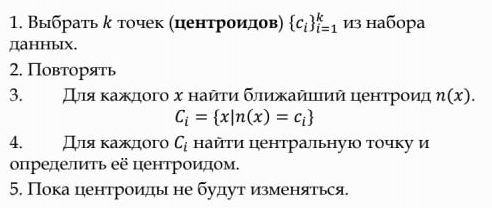

In [23]:
def clusterize(x1, countClusters, maxStep):
    curCentroids = initialize(x1, countClusters)
    for i in range(maxStep):
        size = []
        for j in range(countClusters):
            size.append(0)
        sizeClust = np.array(size)
        sumClust = np.zeros((countClusters, x1.shape[1]))
        for curPoint in x1:
            indexCentroid = findMinDist(curCentroids, curPoint)[0]
            sizeClust[indexCentroid] += 1
            sumClust[indexCentroid] += curPoint
        updCentroids = np.copy(curCentroids)
        for j in range(countClusters):
            if (sizeClust[j]) == 0:
                continue
            updCentroids[j] = sumClust[j] / sizeClust[j]
        minus = curCentroids - updCentroids
        if np.max(np.apply_along_axis(lambda coord: np.linalg.norm(coord), 1, minus)) <= diff:
            break
        curCentroids = updCentroids
    return curCentroids

In [24]:
def getAnswer(x1, countClusters, maxStep):
    centroids = clusterize(x1, countClusters, maxStep)
    return np.apply_along_axis(lambda cur: findMinDist(centroids, cur)[0], 1, x1)

In [25]:
answer = getAnswer(x, 3, 10000)

In [26]:
def display_clusters(labels, title):
    colours = ["c", "m", "k"]
    reducer = PCA(n_components=2)
    xred = reducer.fit_transform(x)
    graphs.figure(figsize=(12, 12))
    unique_labels = np.unique(labels)
    for i in range(len(unique_labels)):
        label = unique_labels[i]
        cur_xs = xred[labels == label, 0]
        cur_ys = xred[labels == label, 1]
        graphs.scatter(cur_xs, cur_ys, color=colours[i], alpha=0.5, label=label)
    graphs.title(title)
    graphs.xlabel("X")
    graphs.ylabel("Y")
    graphs.legend()
    graphs.show()

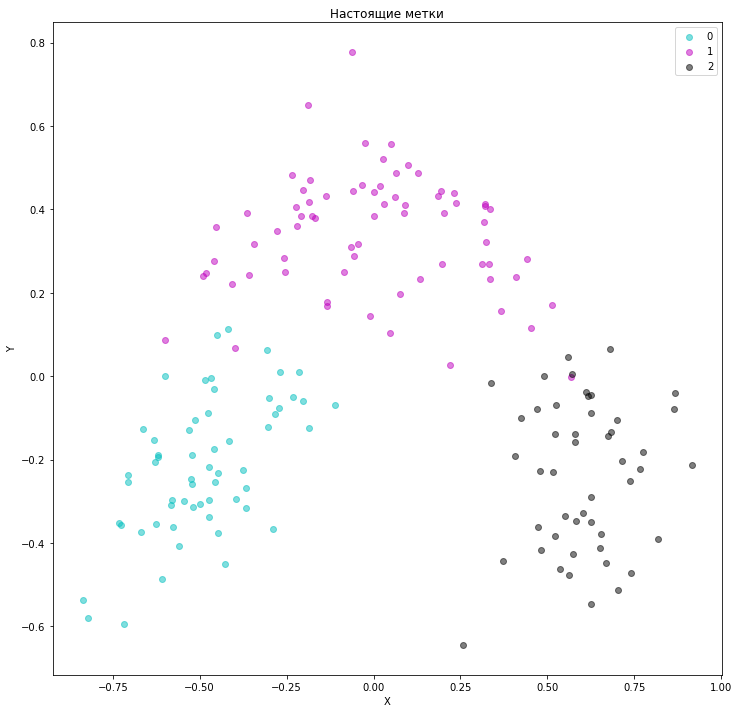

In [27]:
display_clusters(y, "Настоящие метки")

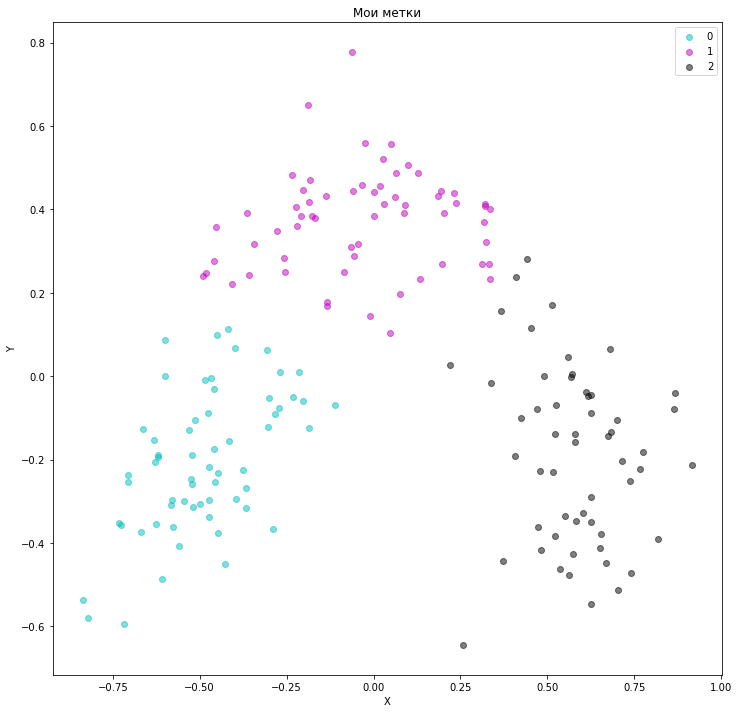

In [28]:
display_clusters(answer, "Мои метки")

# INNER DISTANCE - information only from data

# Индекс Calinski–Harabasz
## Компактность основана на расстоянии от точек кластера до их центроидов, а разделимость - на расстоянии от центроид кластеров до глобального центроида. Должен возрастать.
### Компактность - Идея данного метода в том, что чем ближе друг к другу находятся объекты внутри кластеров, тем лучше разделение. Таким образом, необходимо минимизировать внутриклассовое расстояние, например, сумму квадратов отклонений
### Разделимость - В данном случае идея противоположная — чем дальше друг от друга находятся объекты разных кластеров, тем лучше. Поэтому здесь стоит задача максимизации суммы квадратов отклонений:
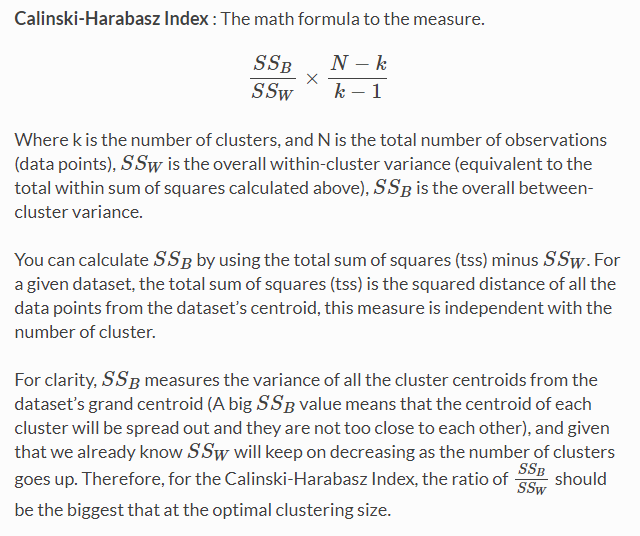

In [29]:
calinski_harabasz_score(x, answer)

83.35112750771908

# EXTERN DISTANCE - based on true information

# Индекс Rand 
## Оценивает, насколько много из тех пар элементов, которые находились в одном классе, и тех пар элементов, которые находились в разных классах, сохранили это состояние после кластеризации алгоритмом
### Имеет область определения от 0 до 1, где 1 — полное совпадение кластеров с заданными классами, а 0 — отсутствие совпадений.

In [30]:
adjusted_rand_score(y, answer)

0.8536602842727953

In [34]:
inner = []
extern = []
for i in range (3, 16):
    curAnswer = getAnswer(x, i, 10000)
    extern.append(adjusted_rand_score(y, curAnswer))
    inner.append(calinski_harabasz_score(x, curAnswer))

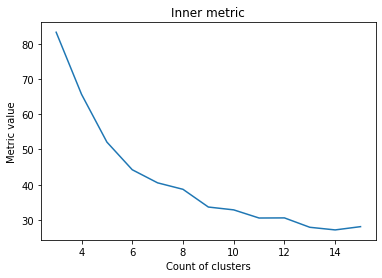

In [35]:
graphs.plot(range(3, 16), inner)
graphs.title("Inner metric")
graphs.ylabel('Metric value')
graphs.xlabel('Count of clusters')
graphs.show()

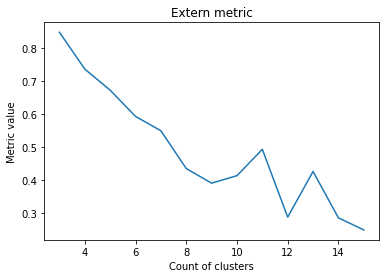

In [36]:
graphs.plot(range(3, 16), extern)
graphs.title("Extern metric")
graphs.ylabel('Metric value')
graphs.xlabel('Count of clusters')
graphs.show()